In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
sys.path.append('../')

from src import load_data

## Loading the data and obtaining a sort of profile histogram

- We load the root file using uproot and show its contents. We can then obtain a dictionary where keys are some of the names shown above and values are numpy arrays containing the data. Note that we only keep a subset of the information.

In [3]:
data_dict = load_data.load_data_as_dict(TTree_features_dict={
                        "t_hk_obox":
                                ["saa", 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               "obox_mode",
                               "fe_temp",
                               "glon", 
                               "glat",
                               "tunix",
                               "fe_cosmic",
                               "fe_rate"],
                        "B_field":
                                ["B_r",
                                 "B_theta",
                                 "B_phi"]
                        })

TTree: t_hk_obox's contents:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
odd_index            | int32_t                  | AsDtype('>i4')
even_index           | int32_t                  | AsDtype('>i4')
odd_is_bad           | int32_t                  | AsDtype('>i4')
even_is_bad          | int32_t                  | AsDtype('>i4')
obox_is_bad          | int32_t                  | AsDtype('>i4')
packet_num           | uint16_t                 | AsDtype('>u2')
timestamp            | uint32_t                 | AsDtype('>u4')
obox_mode            | uint8_t                  | AsDtype('uint8')
cpu_status           | uint16_t                 | AsDtype('>u2')
trig_status          | uint8_t                  | AsDtype('uint8')
comm_status          | uint8_t                  | AsDtype('uint8')
ct_temp              | float                    | AsDtype('>f4')
chain_temp           | 

The TTree `B_field` contains information on the magnetic field and is aligned with the data in `t_hk_obox`

In [4]:
data_dict

{'saa': array([2, 2, 2, ..., 2, 2, 2], dtype=uint16),
 'raz': array([120.61032988, 120.61032988, 120.61032988, ..., 268.31234659,
        268.46116213, 268.61028861]),
 'decz': array([-29.61894939, -29.61894939, -29.61894939, ..., -31.63597884,
        -31.64401894, -31.6515442 ]),
 'rax': array([ 92.82497914,  92.82497914,  92.82497914, ..., 275.36921754,
        275.31124104, 275.25286591]),
 'decx': array([57.27482107, 57.27482107, 57.27482107, ..., 58.16912315,
        58.17235735, 58.17580668]),
 'obox_mode': array([1, 1, 1, ..., 4, 4, 4], dtype=uint8),
 'fe_temp': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'glon': array([-176.248994  , -176.14829434, -176.04746684, ...,  171.5605    ,
         171.72805   ,  171.8957    ]),
 'glat': array([-18.1458175 , -18.23102

- We are interested in the following curve which contains a background part and the gamma ray bursts we would like to detect:

In [5]:
tunix = data_dict["tunix"]
sum_fe_rate = np.sum(data_dict["fe_rate"], axis=1)

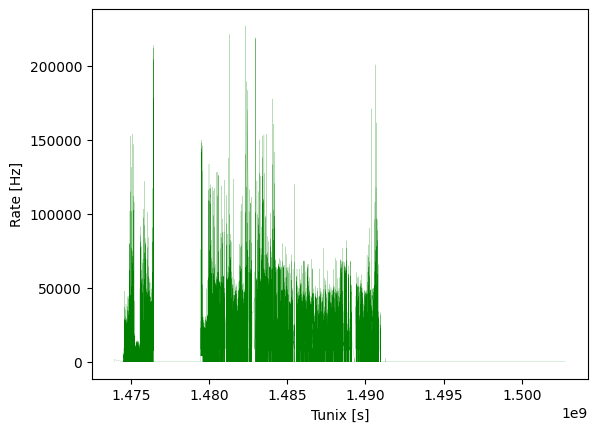

In [6]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # Nb. photons per second
plt.show()

Therefore, we would like to predict the background part, subtract it from the curve and analyze or use the remaining part to detect gamma ray bursts (GRB).

As we can see from the previous plot, we see a large flat region on the right with no data. We can therefore crop the right part:

In [7]:
last_non_zero = sum_fe_rate.size-(np.flip(sum_fe_rate)>0).argmax() - 1
tunix = tunix[:last_non_zero+1]
sum_fe_rate = sum_fe_rate[:last_non_zero+1]

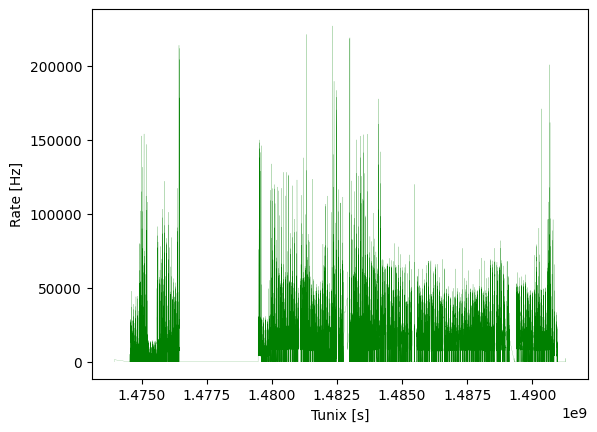

In [8]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # Nb. photons per second
plt.show()

We can observe a lot of missing values due to the detector being switched off when astronauts went onboard the space station. Small missing values are due to the South Altantic Anomaly region.

- We can shift the time axis so that it starts at $0$. We can also bin the data

In [9]:
tunix_min = tunix.min()
tunix_shifted = tunix - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)

In [10]:
pd.DataFrame(bins[uniques_idx].reshape(1, -1))

,0,1,2,3,4,5,6,7,8,9,...,6187613,6187614,6187615,6187616,6187617,6187618,6187619,6187620,6187621,6187622
0,2.0,4.0,6.0,10.0,12.0,18.0,20.0,26.0,28.0,34.0,...,17323018.0,17323020.0,17323022.0,17323024.0,17323026.0,17323028.0,17323030.0,17323032.0,17323034.0,17323036.0


We can observe that the bins start at $2$ seconds and this should be taken into account in the future.

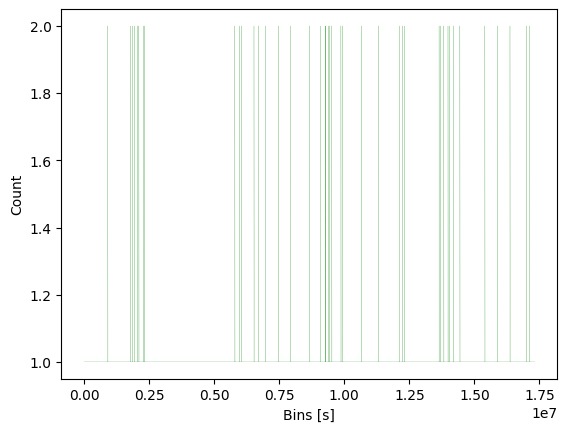

In [11]:
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

- There are sometimes two data points in a bin, we can average the data falling into each bin (profile hist but without error bars).

In [12]:
# Quantized Shifted Time
t = bins[indices_digitized]

# First column is the quantized time, second is the 'average' rate within the bin
light_curve = np.array(pd.DataFrame(np.vstack([t, sum_fe_rate, indices_digitized]).T, 
                                    columns=["t", "sum_fe_rate", "idx"]).groupby("idx").mean())

In [13]:
t, y = light_curve.T

In [14]:
t.shape, y.shape

((6187623,), (6187623,))

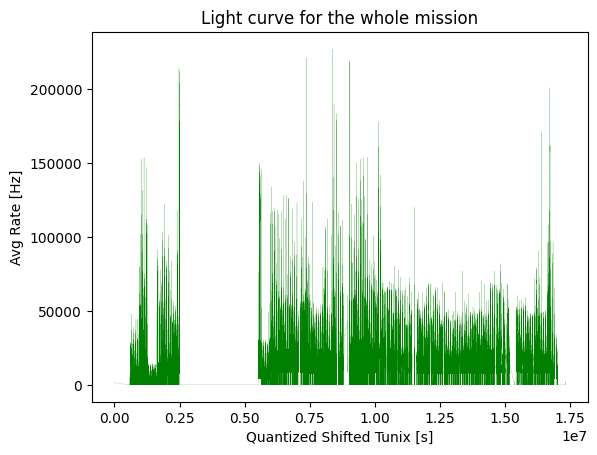

In [15]:
plt.plot(t, y, 'g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

- Let's visualize just a small part of it (not the whole mission):

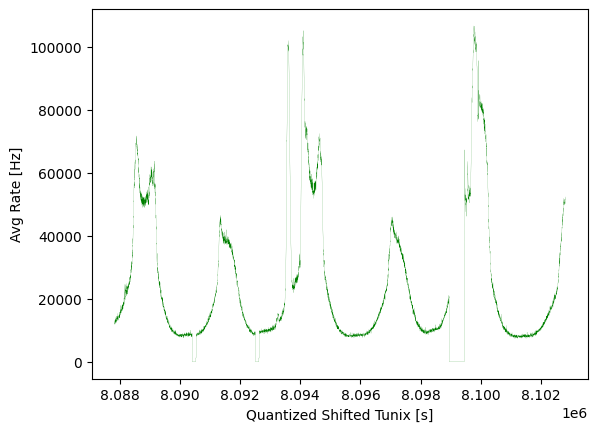

In [16]:
# Mask used to select a portion of the mission
mask = (t>(5000+1482032854-tunix_min)) & (t<(20000+1482032854-tunix_min))

plt.plot(t[mask], y[mask], '-g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

---

## Fourier Transform

In [17]:
from src.frequencies import f_after_first, f, compute_freqs, get_freqs_hour
from src.plotting import plot_magnitude_w_first_freq,\
    plot_magnitude_wo_first_freq,\
    plot_phase_w_first_freq,\
    plot_phase_wo_first_freq,\
    plot_quantity_wrt_freqs,\
    plot_quantity_wo_first_freq,\
    plot_quantity_w_first_freq

- Direct transform

In [18]:
fft_res = np.fft.rfft(y)

Just checking the Fourier synthesis, that we come back to the original light curve

In [19]:
y_hat = np.fft.irfft(fft_res, n=y.size)

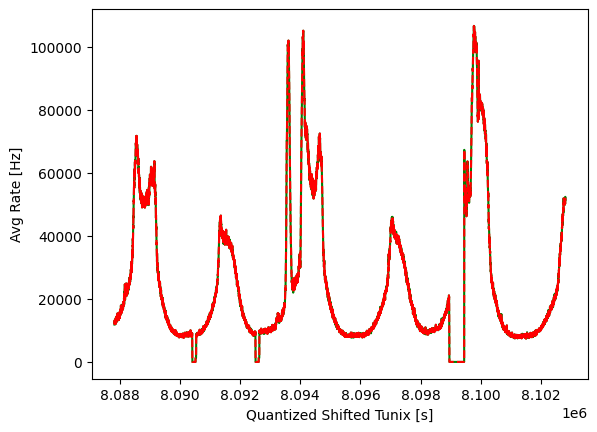

In [20]:
# Mask used to select a portion of the mission
mask = (t>(5000+1482032854-tunix_min)) & (t<(20000+1482032854-tunix_min))

plt.plot(t[mask], y[mask], '-g')
plt.plot(t[mask], y_hat[mask], '--r')
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

- Frequency axis

In [21]:
freqs = compute_freqs(y.size, timestep=2)  # timestep of 2 seconds

In [22]:
freqs_hour = get_freqs_hour(freqs)

- Plotting the magnitude and the phase (without the first one)

In [23]:
mag = np.abs(fft_res)
phase = np.angle(fft_res)

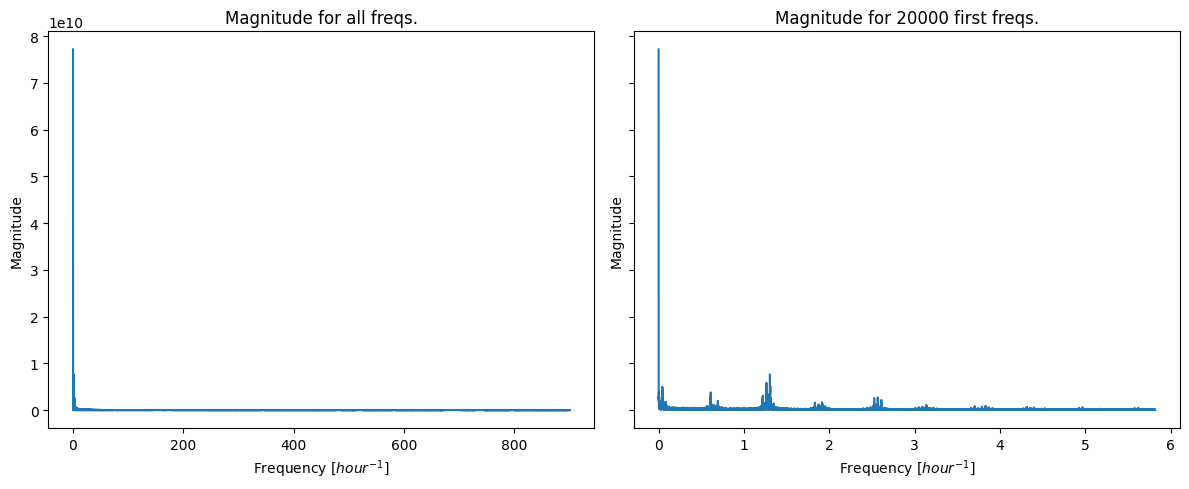

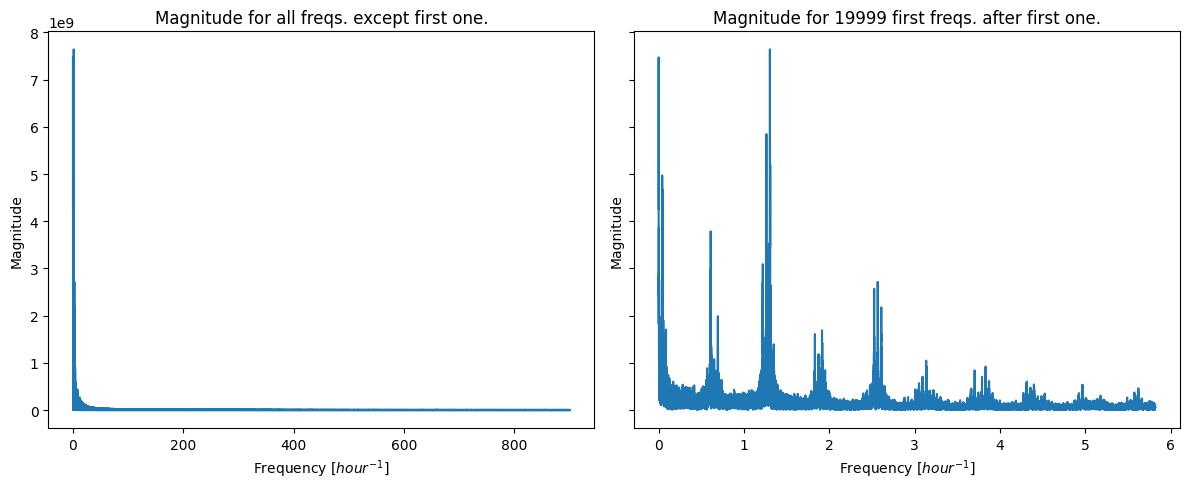

In [24]:
plot_magnitude_w_first_freq(mag, y.size, n=20000)
plot_magnitude_wo_first_freq(mag, y.size, n=20000)

Phase (TODO, make it more interpretable):

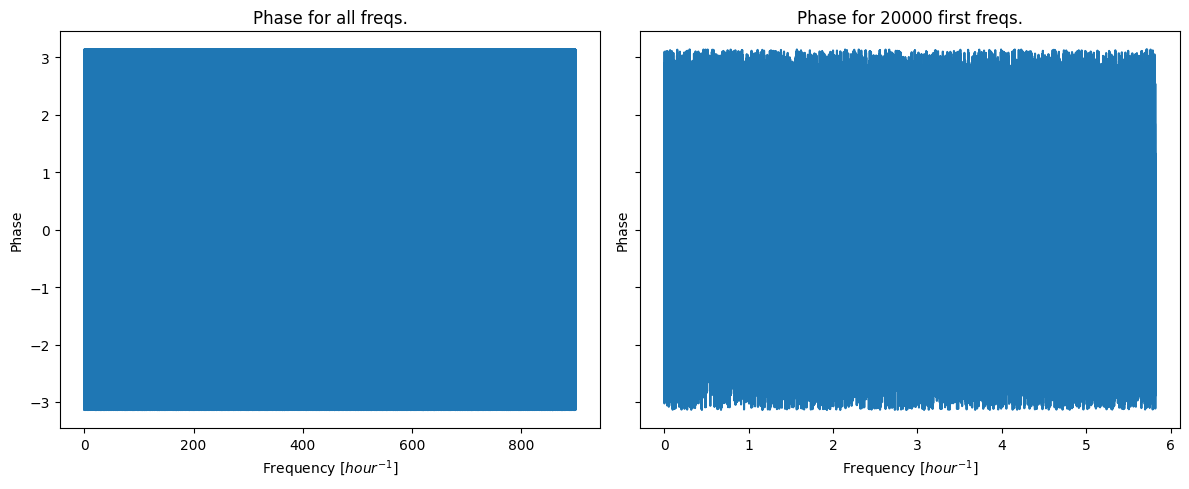

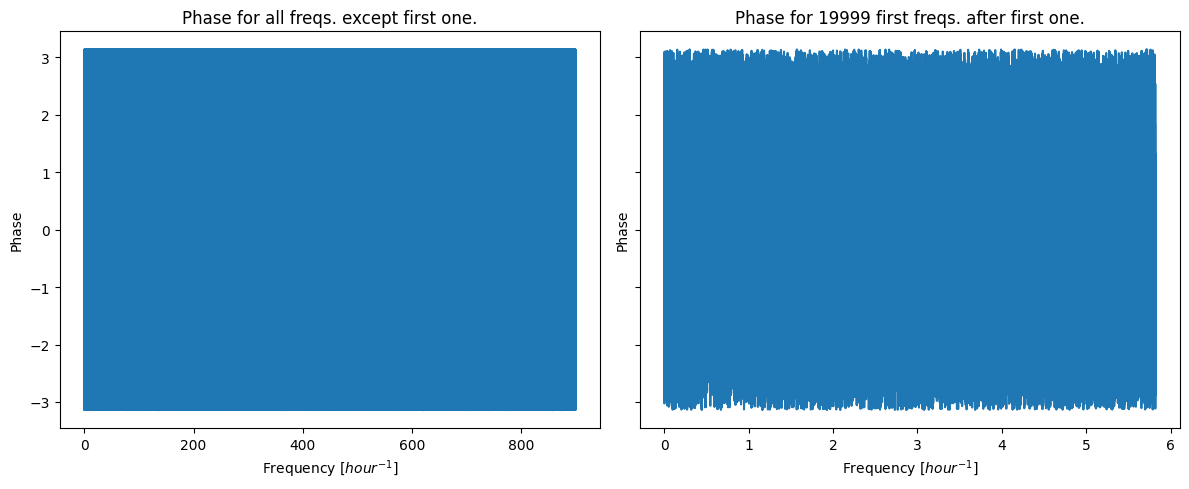

In [25]:
plot_phase_w_first_freq(phase, y.size, n=20000)
plot_phase_wo_first_freq(phase, y.size, n=20000)

Not very interpretable

And for even smaller subsets

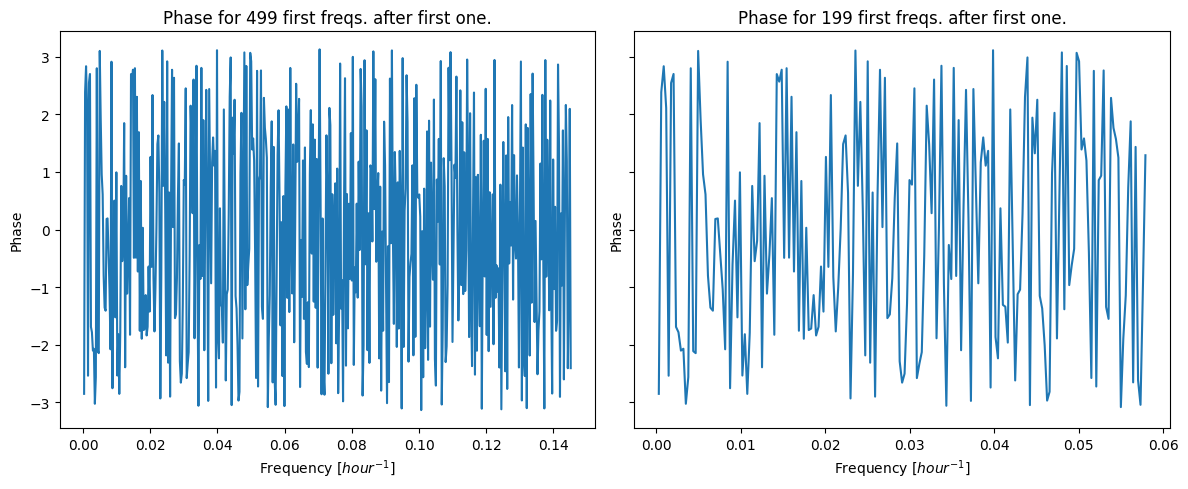

In [26]:
n = 500  # number of frequencies to show

fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_quantity_wrt_freqs(axs2[0], phase, "Phase", y.size, low_n=1, high_n=n)


n = 200  # number of frequencies to show
plot_quantity_wrt_freqs(axs2[1], phase, "Phase", y.size, low_n=1, high_n=n)
plt.tight_layout()
plt.show()

Placing a line at the mean:

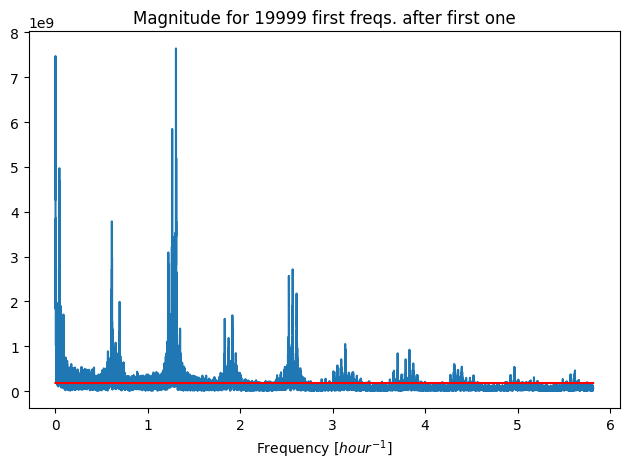

In [27]:
n = 20000  # number of frequencies to show

plt.plot(f_after_first(y.size, n), mag[1:n])
plt.plot(f_after_first(y.size, n),
         np.mean(mag[:n])*np.ones(n-1), 'r')
plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

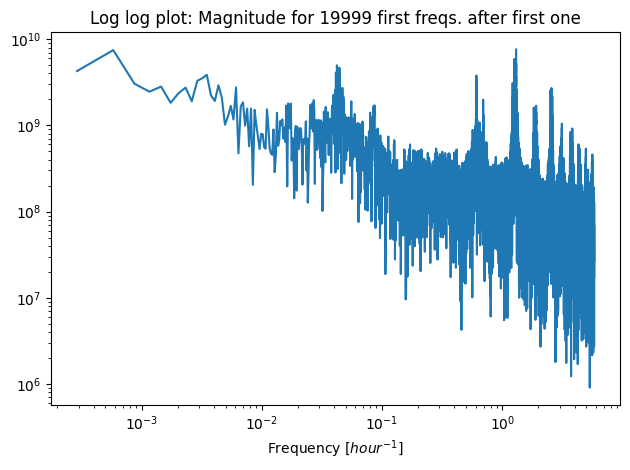

In [28]:
n = 20000  # number of frequencies to show

plt.loglog(f_after_first(y.size, n), mag[1:n])
plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Log log plot: Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Let's try to fit a power law and use it to apply local means on specific regions

In [29]:
x_tmp = np.log(f_after_first(y.size, n))
y_tmp = np.log(mag[1:n])

In [30]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tmp, y_tmp)
print(slope, intercept, r_value, p_value, std_err)

-0.4561899633444006 18.844238293990262 -0.4911029956949334 0.0 0.0057221532920807075


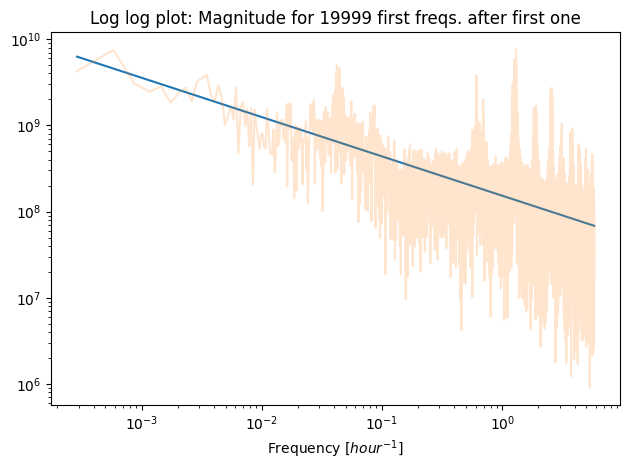

In [31]:
n = 20000  # number of frequencies to show

plt.plot(f_after_first(y.size, n),
         np.exp(slope*x_tmp + intercept),
         label="Linear regression 'using log'")

plt.loglog(f_after_first(y.size, n), mag[1:n],
          alpha=0.2)

plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Log log plot: Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

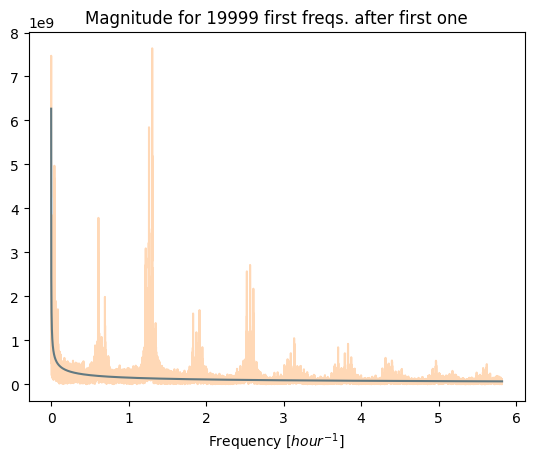

In [32]:
n = 20000  # number of frequencies to show

plt.plot(f_after_first(y.size, n),
         np.exp(slope*x_tmp + intercept),
         label="Linear regression 'using log'")

plt.plot(f_after_first(y.size, n), mag[1:n], alpha=0.3)

plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Magnitude for {n-1} first freqs. after first one")
plt.show()

## Convolution with box filter in Fourier domain

TODO: we wanted to kill the spikes in the magnitude and reconstruct back the signal

- Over the whole Fourier domain

In [33]:
window_size = 100
mag_convolved = np.convolve(mag, np.ones(window_size)/window_size, "same")
# TODO: only do it for the big spikes and try with different window lengths
# TODO: be careful about padding !!

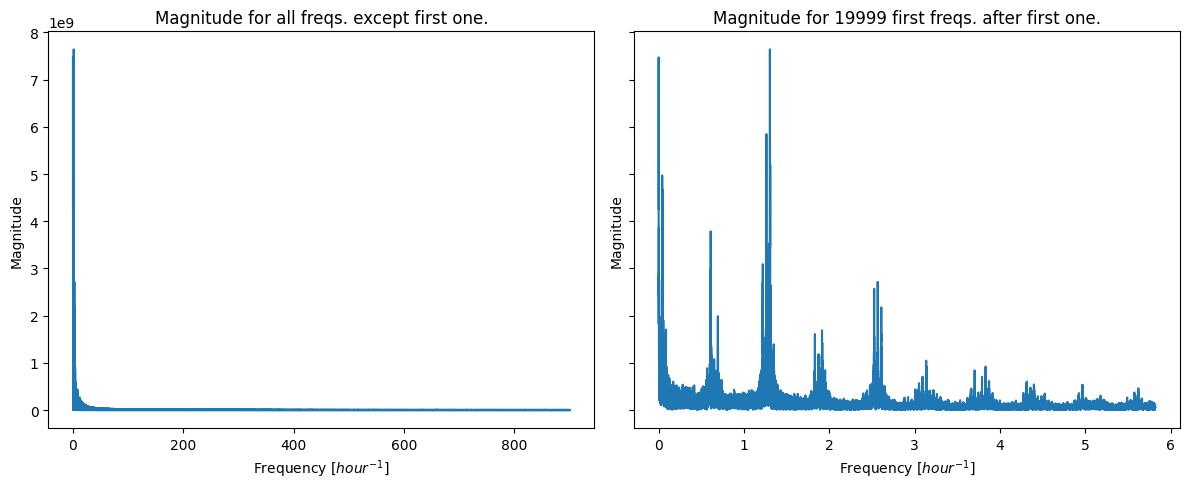

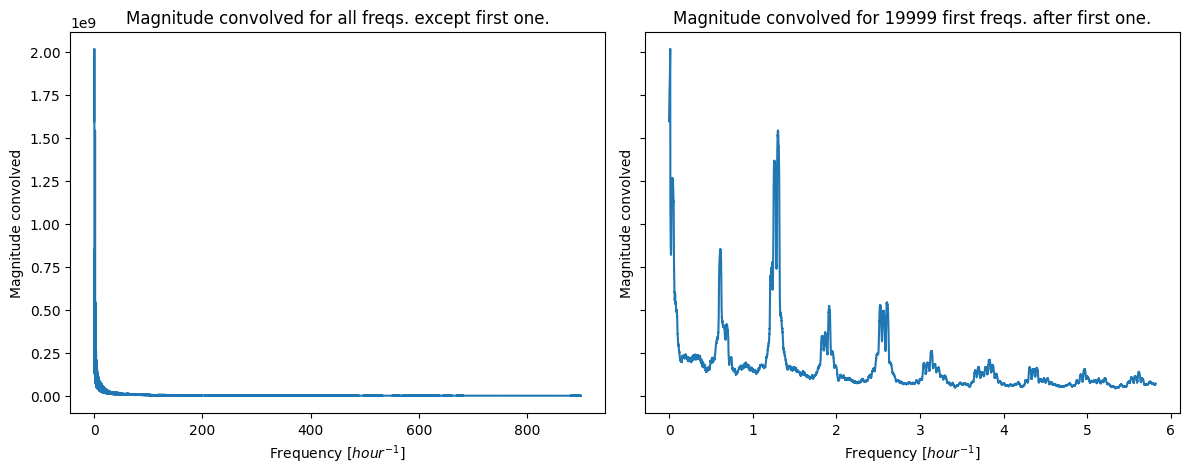

In [34]:
n = 20000  # number of frequencies to show

plot_quantity_wo_first_freq(mag, "Magnitude", y.size, n=n)
plot_quantity_wo_first_freq(mag_convolved, "Magnitude convolved", y.size, n=n)

In [35]:
t.shape, mag.shape

((6187623,), (3093812,))

In [36]:
reconstructed = np.fft.irfft(mag_convolved*np.exp(1j*np.angle(fft_res)), n=y.size)

In [37]:
reconstructed.shape

(6187623,)

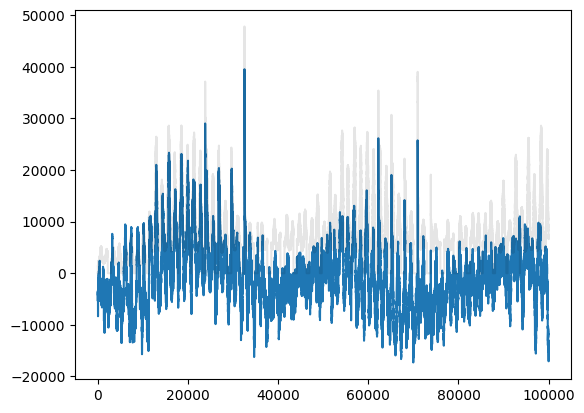

In [38]:
plt.plot(reconstructed[:100000])
plt.plot(y[:100000], 'k', alpha=0.1)

In [39]:
fft_res.shape

(3093812,)

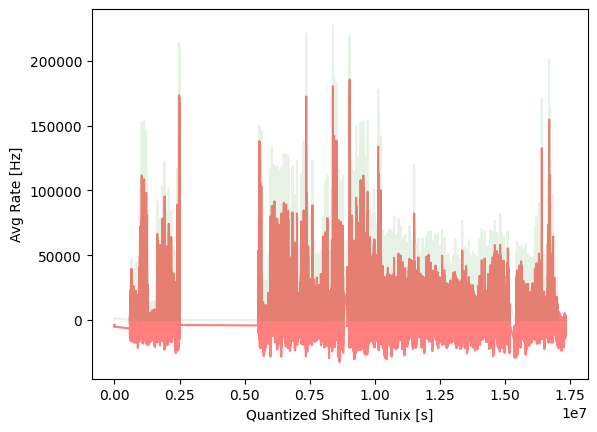

In [40]:
plt.plot(t, reconstructed, 'r', alpha=0.5, label="reconstructed")
plt.plot(t, y, 'g', alpha=0.1, label="light curve")
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

Values below zero doesn't make any sense physically (counts)

In [41]:
reconstructed.size

6187623

In [42]:
y.size

6187623

In [43]:
print(t.min(), t.max())  # TODO: need to take this into account 

2.0 17323036.0


## Killing low frequencies instead


TODO: we wanted to kill the spikes in the magnitude and reconstruct back the signal but now we want to keep most them except the beginning..

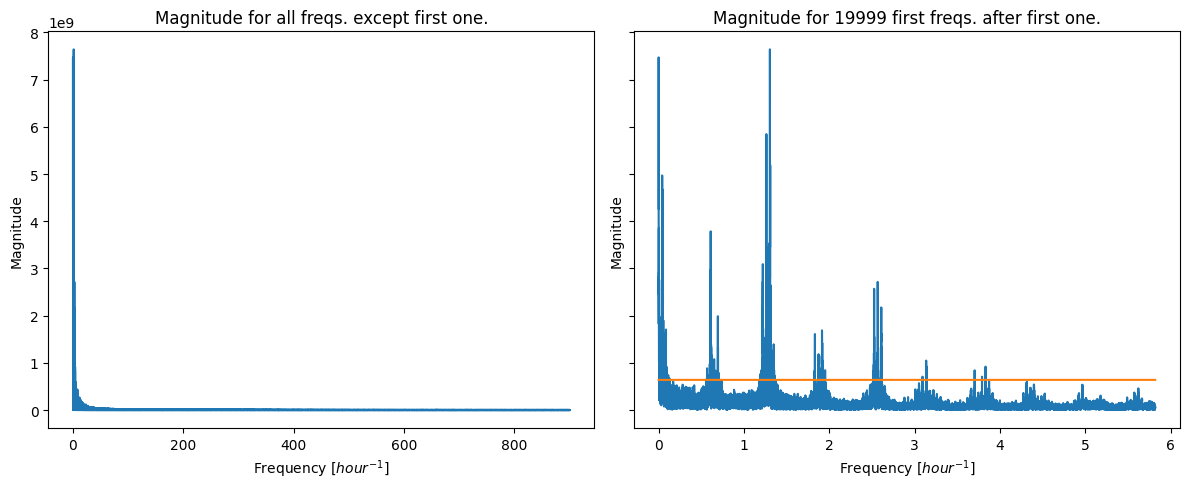

In [44]:
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_quantity_wrt_freqs(axs2[0], mag, "Magnitude", y.size, low_n=1, high_n=None)
plot_quantity_wrt_freqs(axs2[1], mag, "Magnitude", y.size, low_n=1, high_n=n)

axs2[1].plot(f_after_first(y.size, n), np.ones(n-1)*0.64*1e9)  # threshold placed visually..
plt.tight_layout()
plt.show()

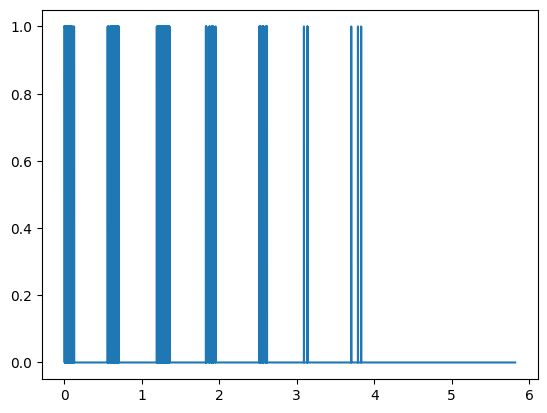

In [45]:
plt.plot(freqs_hour[:n], mag[:n] > 0.64*1e9)

Want to cut at least up to $2.2$ (will cut up to the next peak)

In [46]:
threshold = 3

In [47]:
cropped_fft_res = copy.deepcopy(fft_res)
cropped_fft_res[freqs_hour<=threshold] = 0
cropped_fft_res[:np.argmax(np.abs(cropped_fft_res)>0.64*1e9)] = 0

In [48]:
freqs

array([0.00000000e+00, 8.08064745e-08, 1.61612949e-07, ...,
       2.49999798e-01, 2.49999879e-01, 2.49999960e-01])

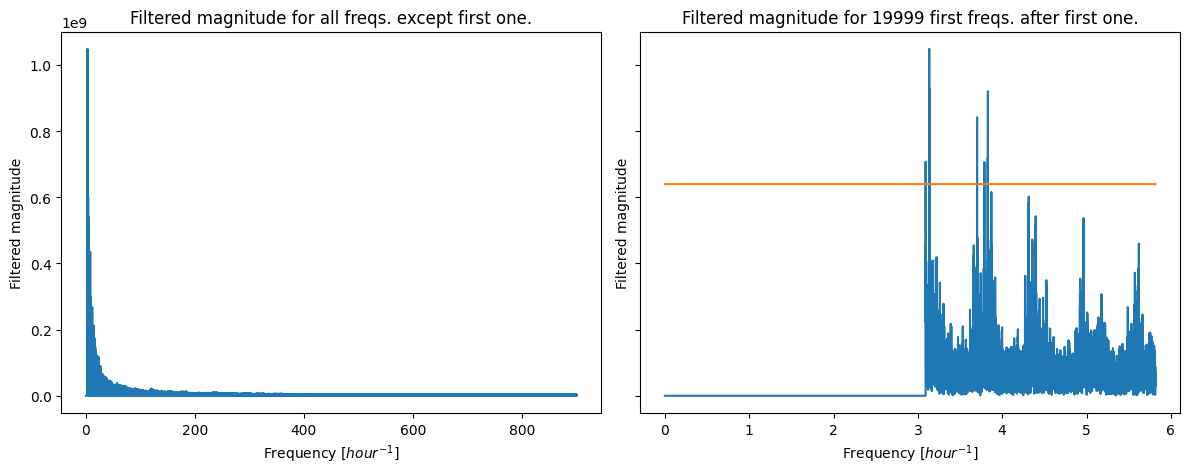

In [49]:
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plot_quantity_wrt_freqs(axs2[0], np.abs(cropped_fft_res), "Filtered magnitude", y.size, low_n=1, high_n=None)
plot_quantity_wrt_freqs(axs2[1], np.abs(cropped_fft_res), "Filtered magnitude", y.size, low_n=1, high_n=n)

axs2[1].plot(f_after_first(y.size, n), np.ones(n-1)*0.64*1e9)  # threshold placed visually..
plt.tight_layout()
plt.show()

- Apply Fourier synthesis to get back a reconstructed signal.

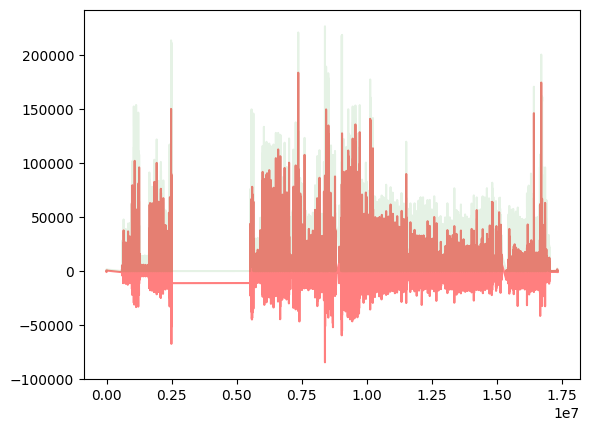

In [50]:
y_hat = np.fft.irfft(cropped_fft_res, n=y.size)

plt.plot(t, y_hat, 'r', alpha=0.5)
plt.plot(t, y, 'g', alpha=0.1)
plt.show()

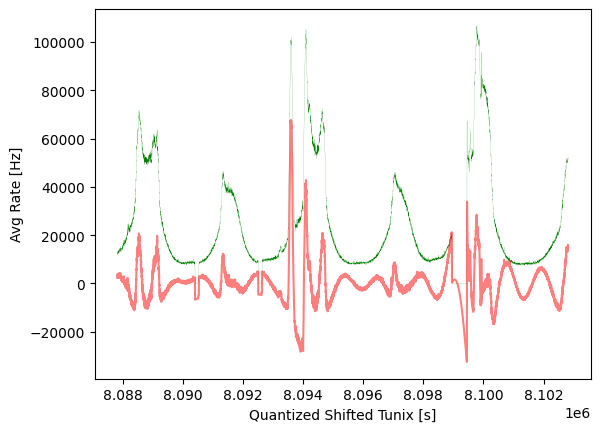

In [51]:
# Mask used to select a portion of the mission
mask = (t>(5000+1482032854-tunix_min)) & (t<(20000+1482032854-tunix_min))

plt.plot(t[mask], y[mask], '-g', linewidth=0.1)
plt.plot(t[mask], y_hat[mask], 'r', alpha=0.5)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

## 